In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit.aqua import QuantumInstance
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import pylab
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.chemistry.transformations import FermionicTransformation, FermionicQubitMappingType
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms import VQE
from qiskit.circuit.library import TwoLocal
import numpy as np

In [2]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
backend = Aer.get_backend("qasm_simulator")
print(backend)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


qasm_simulator


In [3]:
#Set the seed for reproducible results
aqua_globals.random_seed = 100
seed_simulator = 100
seed_transpiler=100
np.random.seed(100)

In [4]:
backend = Aer.get_backend("qasm_simulator")
print(backend)
# available backends
#print(provider.backends())

qasm_simulator


In [5]:
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
transformation = FermionicTransformation(qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER)

numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(transformation, numpy_solver)
res = calc.solve(driver)
energy = -1.137306035753
print (energy)
print (res)

-1.137306035753
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.0]  Total: 0.
 


In [6]:
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [7]:
# Custom noise model

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]   # 2-qubit gate
prob_3 = 0.01   # 2-qubit gate

var_forms = [('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)]),
             ('RY_CZ', 'ry', 'cz', [(2, 3), (1, 2), (0, 1), (0, 3)]),
             ('RYRZ_CX', ['ry', 'rz'], 'cx', 'full'),
             ('RYRZ_CZ', ['ry', 'rz'], 'cz','full'),
             ('HRX_CX', ['h', 'rx'], 'cx', 'full'),
             ('HRX_CZ', ['h', 'rx'], 'cz', 'full')]

energies = np.empty([len(var_forms), len(prob_2)])
print(energies.shape)

for i, j in enumerate(prob_2):
    for k in range(len(var_forms)):
        # Depolarizing quantum errors
        print(var_forms[k])
        print(prob_2[i])
        error_1 = noise.depolarizing_error(prob_1, 1)
        error_2 = noise.depolarizing_error(prob_2[i], 2)
        error_3 = noise.depolarizing_error(prob_3, 2) 

        # Add errors to noise model
        noise_model = noise.NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cz'])
        noise_model.add_all_qubit_quantum_error(error_3, ['cx'])
        
        # Get basis gates from noise model
        basis_gates = noise_model.basis_gates

        print(noise_model)
        print(noise_model.to_dict())

        quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler,
                                       basis_gates=basis_gates, noise_model=noise_model)

        num_qubits = 4
        optimizer = SPSA(maxiter=200)
        tl_circuit = TwoLocal(num_qubits, var_forms[k][1], var_forms[k][2], reps=1, entanglement=var_forms[k][3], insert_barriers=True)
        vqe_solver = VQE(var_form = tl_circuit, quantum_instance = quantum_instance, optimizer= optimizer, callback=store_intermediate_result) 
        calc = GroundStateEigensolver(transformation, vqe_solver)
        result = calc.solve(driver)
        energies[k][i] = result.groundenergy + 0.719968994449
        print(energies[k][i])
        
print('Energies:', energies)

(6, 10)
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.01
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qer

-1.0841498990945044
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.01
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror'

-0.3305211174949818
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.02
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {

-1.0788497884239643
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.02
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror'

-0.30197908062217005
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.03
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, 

-1.0821368350535017
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.03
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror'

-0.31198171162646027
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.04
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, 

-1.0769636803871923
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.04
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror'

-0.27512926263188753
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.05
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, 

-1.0792756160445092
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.05
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror'

-0.2789197585316092
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.06
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {

-1.1071319562751174
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.06
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror'

-0.3928760918535168
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.07
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {

-1.077701299362834
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.07
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror',

-0.3706498479880793
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.08
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {

-1.0907030046912483
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.08
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror'

-0.3515300256308147
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.09
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {

-1.084549444385395
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.09
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror',

-0.24832991989665432
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
0.1
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {

-1.0847005812916408
('RYRZ_CZ', ['ry', 'rz'], 'cz', 'full')
0.1
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'cz', 'cx']
{'errors': [{'type': 'qerror', 'operations': ['u1'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u2'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror', 'operations': ['u3'], 'instructions': [[{'name': 'x', 'qubits': [0]}], [{'name': 'y', 'qubits': [0]}], [{'name': 'z', 'qubits': [0]}], [{'name': 'id', 'qubits': [0]}]], 'probabilities': [0.00025, 0.00025, 0.00025, 0.99925]}, {'type': 'qerror',

-0.32986659253102046
Energies: [[-1.09989222 -1.05380524 -1.10375972 -1.10214724 -1.0307335  -1.10417086
  -1.10460486 -1.10047972 -0.50008038 -1.10030014]
 [-1.10364375 -1.08210498 -1.06270651 -1.05401093 -1.02601455 -1.00306712
  -0.98642471 -0.96602214 -0.91799589 -0.93420223]
 [-1.0841499  -1.07884979 -1.08213684 -1.07696368 -1.07927562 -1.10713196
  -1.0777013  -1.090703   -1.08454944 -1.08470058]
 [-1.08840764 -1.05416167 -1.0272506  -0.98021619 -0.96386017 -0.91634927
  -0.89638107 -0.87347525 -0.84538248 -0.80858148]
 [-1.08832343 -0.50121799 -1.0873032  -1.08698976 -1.08834066 -1.08834066
  -1.08726328 -1.08805839 -1.08709531 -1.08860569]
 [-0.33052112 -0.30197908 -0.31198171 -0.27512926 -0.27891976 -0.39287609
  -0.37064985 -0.35153003 -0.24832992 -0.32986659]]


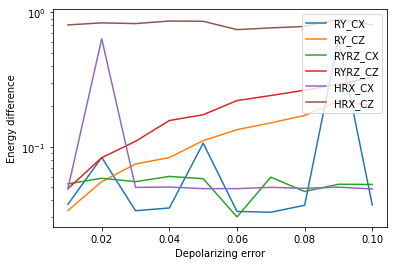

In [8]:
for k in range(len(var_forms)):
    pylab.plot(prob_2, energies[k]-energy, label=var_forms[k][0])
pylab.xlabel('Depolarizing error')
pylab.ylabel('Energy difference')
pylab.yscale('log')
#pylab.title('H2 Ground State Energy Difference from Reference')
pylab.legend(loc='upper right');